In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
import os

sys.path.append(os.path.join(os.path.abspath('.'),'../../plankton'))

In [2]:
import plankton as pl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
data_folder='data/'

umpp=0.152

coordinates = pd.read_csv(os.path.join(data_folder,'./coordinates_joined.csv'))
mask = ~coordinates.gene.isin(['CGA','KISS1'])
mask[np.random.uniform(size=mask.size)<0.3]=True

dapi_image = plt.imread(os.path.join(data_folder,'156KS_FITC_backround.tif')).sum(-1)
dapi_image -=dapi_image.min()
dapi_image = 1-(dapi_image/dapi_image.max())**0.7

# bg_cells= np.load('./data/leftCA1/label_image.coo.npz')
# cell_mask = np.zeros(bg_cells['shape'])
# cell_mask[bg_cells['row'],bg_cells['col']]=bg_cells['data']

In [5]:
data_folder='/home/sebastian/data/hpa-HnE-data/ISS/'

umpp=0.152

coordinates = pd.read_csv(os.path.join(data_folder,'./102KS_small_Decoded_LowThreshold.csv'))
# mask = ~coordinates.gene.isin(['CGA','KISS1'])
# mask[np.random.uniform(size=mask.size)<0.3]=True

dapi_image = plt.imread(os.path.join(data_folder,'102ks_bg_mock_HnE.jpg')).sum(-1)
dapi_image -=dapi_image.min()
dapi_image = 1-(dapi_image/dapi_image.max())**0.7

# bg_cells= np.load('./data/leftCA1/label_image.coo.npz')
# cell_mask = np.zeros(bg_cells['shape'])
# cell_mask[bg_cells['row'],bg_cells['col']]=bg_cells['data']

In [6]:
0.25*2.91

0.7275

In [7]:
sdata = pl.SpatialData(genes=coordinates.gene,
                       x_coordinates=coordinates.Y*umpp+13,
                       y_coordinates=coordinates.X*umpp+13,
                      pixel_maps=[pl.PixelMap(dapi_image,upscale=0.25/umpp*2.91),])

(<matplotlib.collections.PathCollection at 0x7feb453285e0>, None, None)

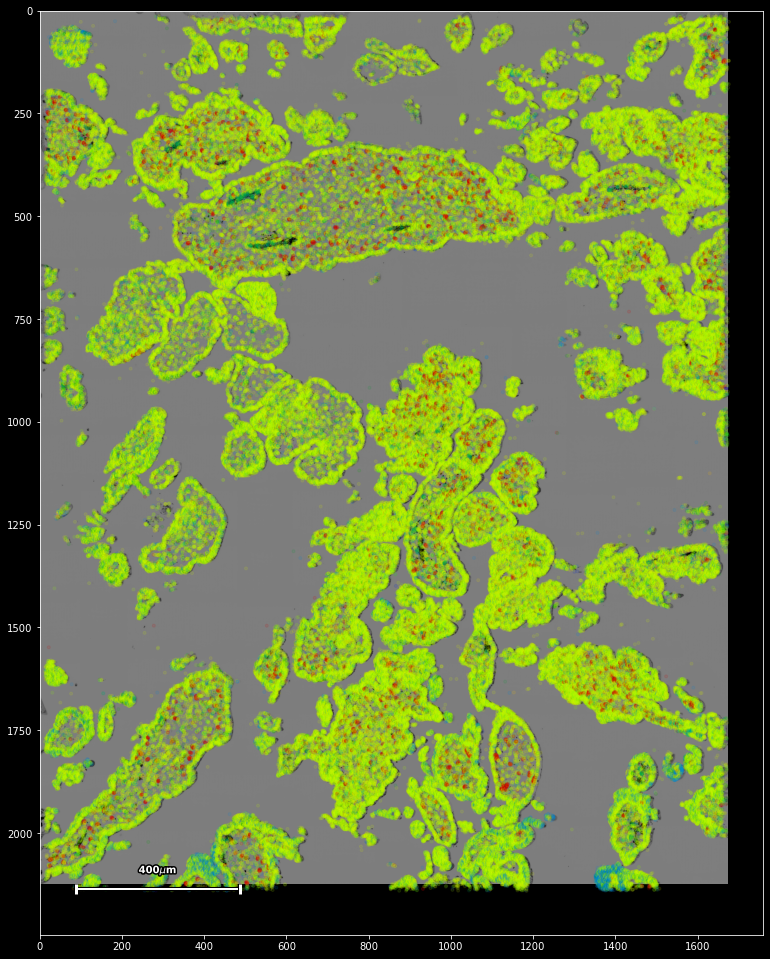

In [8]:
plt.figure(figsize=(17,17))
sdata.scatter(alpha=0.1,marker='.')

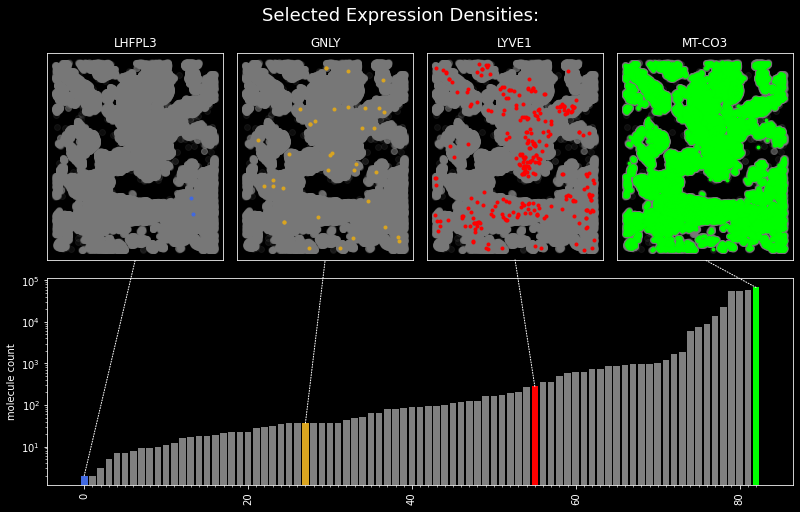

In [56]:
sdata.plot_overview()

In [12]:
knn_neighbors=160
bandwidth=5
n_neighbors=30
metric='euclidean'
min_dist=0.03
random_state=42
zero_weight=2
zero_weight=0

_=sdata.graph.update_knn(n_neighbors=knn_neighbors)

sdata.graph.run_umap(bandwidth=bandwidth,n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state,zero_weight=zero_weight)



<IPython.core.display.Javascript object>


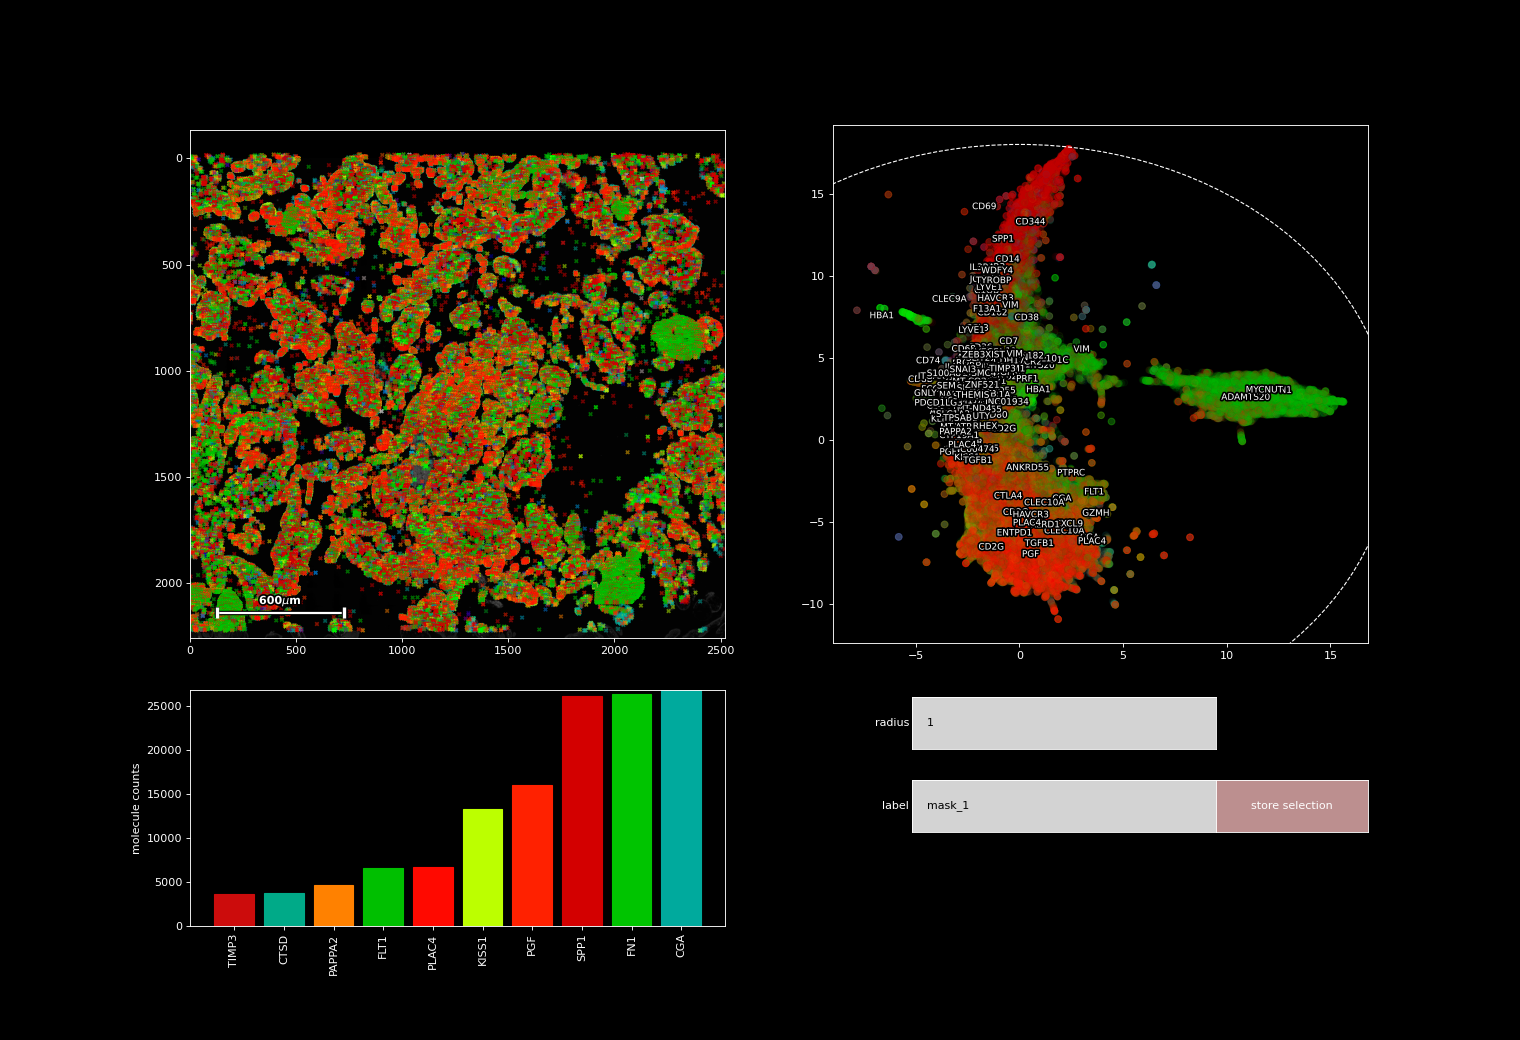

In [13]:
%matplotlib notebook

plt.style.use('dark_background')

plt.figure(figsize=(19,13))
sdata.graph.umap_interactive(color_prop='genes',umap_kwargs={'alpha':0.05,'thlds_text':[0.8,0.03,200],'text_distance':1.5,'legend':False,'text_kwargs':{'fontsize':8},'text_prop':'genes'})

<IPython.core.display.Javascript object>


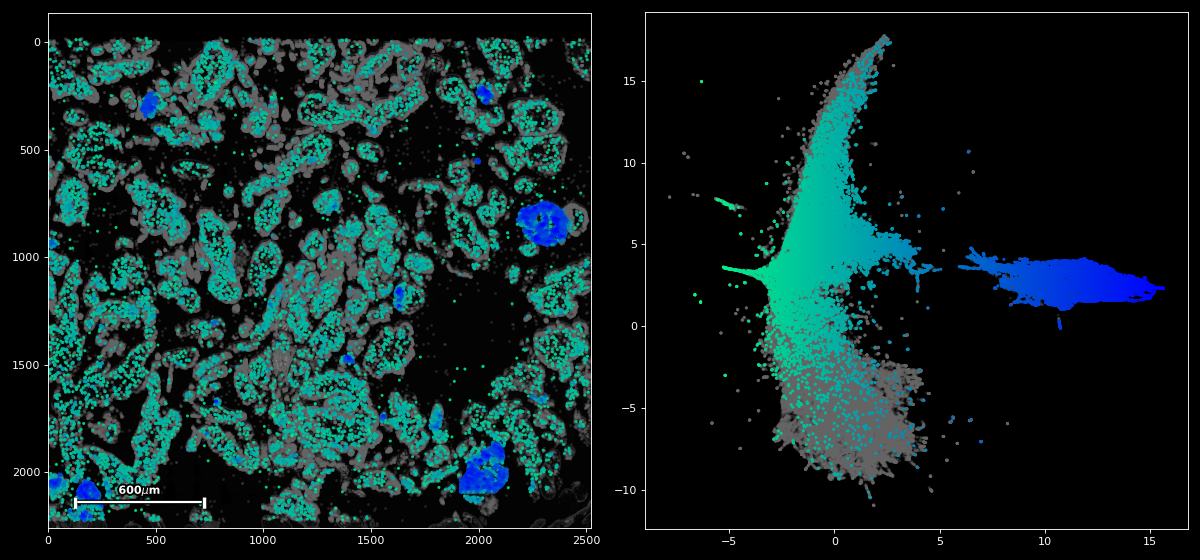

In [14]:
plt.figure(figsize=(15,7))

clr = 'dimgrey'
cmap = 'winter'
plt.subplot(121)
sdata[sdata.g!='FN1'].scatter(color=clr,s=3,alpha=0.2)
sdata[sdata.g=='FN1'].scatter(c=-sdata[sdata.g=='FN1'].graph.umap[:,0],alpha=0.8,cmap=cmap,s=3)

plt.subplot(122)
sdata[sdata.g!='FN1'].graph.plot_umap(color=clr,s=3,alpha=0.2)
sdata[sdata.g=='FN1'].graph.plot_umap(c=-sdata[sdata.g=='FN1'].graph.umap[:,0],cmap=cmap,s=3)

plt.tight_layout()

In [15]:
import plotly.express as px
from scipy.stats import binom

import plotly.graph_objects as go
from ipywidgets import widgets, interactive, HBox, VBox,Output,Layout

import pandas as pd

n_bars=20

f_scatter = go.FigureWidget(px.imshow(np.repeat(sdata.pixel_maps[0].data[:,:,None],3,axis=-1,),
                          x=np.linspace(sdata.background.extent[0],sdata.background.extent[1],sdata.background.data.shape[0]),
                         y=np.linspace(sdata.background.extent[2],sdata.background.extent[3],sdata.background.data.shape[1])
                         ),
                layout=Layout(border='solid 4px',width='100%'))

trace_scatter=go.Scattergl(x=sdata.x,
                           y=sdata.y,
                           mode='markers', 
                           marker=dict(color=sdata.obsc.project('c_genes')),
                           hoverinfo='none',meta={'name':'tissue-scatter'},
                           unselected={'marker':{'color':'black','opacity':0.2}},
                          )

f_scatter.add_trace(trace_scatter)

f_umap = go.FigureWidget(go.Scattergl(x=sdata.graph.umap[:,0],
                                      y=sdata.graph.umap[:,1],
                                      mode='markers', 
                                      marker=dict(color=sdata.obsc.project('c_genes')),
                                       unselected={'marker':{'color':'black','opacity':0.2}},
                                      hoverinfo='none',meta={'name':'umap-scatter'}),
                        )

colors=sdata.obsc.loc[sdata.stats.sort_values('counts')[-n_bars:].index,'c_genes'].values

w_bars=go.Bar(                  x=sdata.stats.sort_values('counts')[-n_bars:].index,
                                y=sdata.stats.sort_values('counts')[-n_bars:]['counts'],
                                marker={'color':['rgb'+str(tuple((np.array(c)*256).astype(int))) for c in  colors]},
                               )
f_bars = go.FigureWidget(w_bars)

f_bars.data[0]['showlegend']=False



w_bars_ratio_up=go.Bar(         x=sdata.stats.sort_values('counts')[-n_bars:].index,
                                y=[0]*n_bars,
                                marker={'color':['rgb'+str(tuple((np.array(c)*256).astype(int))) for c in  colors]},
                               )
f_bars_ratio_up = go.FigureWidget(w_bars_ratio_up)

f_bars_ratio_up.data[0]['showlegend']=False



w_bars_binom=go.Bar(         x=sdata.stats.sort_values('counts')[-n_bars:].index,
                                y=[0]*n_bars,
                                marker={'color':['rgb'+str(tuple((np.array(c)*256).astype(int))) for c in  colors]},
                               )
f_bars_binom = go.FigureWidget(w_bars_binom)

f_bars_binom.data[0]['showlegend']=False

out = widgets.Output(layout={'border': '1px solid black'})

def update_bars(plot,points,selector):
    
    if plot['meta']['name']=='tissue-scatter':
        f_umap.data[0].selectedpoints=plot.selectedpoints
        
    else:
        f_scatter.data[1].selectedpoints=plot.selectedpoints
        
    subset=sdata[np.array(points.point_inds)]
    
    colors=subset.obsc.loc[subset.stats.sort_values('counts')[-n_bars:].index,'c_genes'].values
    colors=['rgb'+str(tuple((np.array(c)*256).astype(int))) for c in  colors]
    ys = subset.stats.sort_values('counts')[-n_bars:]['counts']
    xs = subset.stats.sort_values('counts')[-n_bars:].index
    
    f_bars.data[0].marker.color=colors
    f_bars.data[0].x=xs
    f_bars.data[0].y=ys
    
    vals= (subset.stats.counts)/ (sdata.stats.loc[subset.stats.index].counts)
    idcs = np.argsort(vals)
    
    colors=subset.obsc['c_genes'][idcs]
    colors=['rgb'+str(tuple((np.array(c)*256).astype(int))) for c in  colors]
    ys = vals[idcs]
    xs = subset.stats.index[idcs]
    
    f_bars_ratio_up.data[0].marker.color=colors[-n_bars:]
    f_bars_ratio_up.data[0].x=xs[-n_bars:]
    f_bars_ratio_up.data[0].y=(ys[-n_bars:])
    
    vals= binom.cdf(subset.stats.counts,sdata.stats.loc[subset.stats.index].counts,len(subset)/len(sdata))
    idcs = np.argsort(vals)
    
    colors=subset.obsc['c_genes'][idcs]
    colors=['rgb'+str(tuple((np.array(c)*256).astype(int))) for c in  colors]
    ys = vals[idcs]
    xs = subset.stats.index[idcs]
    
    f_bars_binom.data[0].marker.color=colors[-n_bars:]
    f_bars_binom.data[0].x=xs[-n_bars:]
    f_bars_binom.data[0].y=(ys[-n_bars:])
    
    
    
f_scatter.data[1].on_selection(update_bars)
f_umap.data[0].on_selection(update_bars)

text_field=widgets.Text(
    value='selection1',
    placeholder='Label for storing',
    description='Name:',
    disabled=False
)

store_button = widgets.Button(
    description='store selection',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)
    
def store_selection(event):
    sdata[text_field.value]=pd.Series(np.arange(len(sdata))).isin(f_umap.data[0].selectedpoints)
    []
store_button.on_click(store_selection)
    
reset_button = widgets.Button(
    description='reset selection',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)


fig = widgets.VBox([widgets.HBox([f_scatter,f_umap] ,layout=Layout(display='flex',width='100%',height='80%',border='red solid 1px',align_items='stretch',justify_content='space-around',flex_direction='row')),
                    widgets.HBox([widgets.HBox([f_bars,f_bars_ratio_up,f_bars_binom],layout=Layout(display='flex',width='80%')),
                                  widgets.VBox([widgets.HBox([text_field,
                                                              store_button
                                                             ]),widgets.HBox([reset_button])],layout=Layout(display='flex',width='20%',height='100%',border='red solid 1px',justify_content='space-around',flex_direction='column')
                                              )]
                                )]
                   
                   ,layout=Layout(width='100%',height='80vh',background='red',border='solid 1px'))


In [17]:
import pdb

pdb.run("sdata[sdata.g.isin(['CGA', 'CTSW', 'CYP19A1'])].stats.co_occurrence()")

None
> <string>(1)<module>()

ipdb> c
> /home/sebastian/src/planktonpy/plankton/stats.py(71)co_occurrence()
     69 
     70     pdb.set_trace()
---> 71     hists = get_histograms(sdata, category=category)
     72 
     73 

ipdb> n
> /home/sebastian/src/planktonpy/plankton/stats.py(74)co_occurrence()
     72 
     73 
---> 74     if max_radius is None:
     75         max_radius=np.ceil(np.min(hists[0].shape)/4).astype(int)
     76     else:

ipdb> n
> /home/sebastian/src/planktonpy/plankton/stats.py(75)co_occurrence()
     73 
     74     if max_radius is None:
---> 75         max_radius=np.ceil(np.min(hists[0].shape)/4).astype(int)
     76     else:
     77         max_radius = np.ceil(max_radius/resolution).astype(int)

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(78)co_occurrence()
     76     else:
     77         max_radius = np.ceil(max_radius/resolution).astype(int)
---> 78     if (linear_steps is None) or (linear_steps>=max_radius):
     79         linear_steps=m

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(89)co_occurrence()
     87     fshape = [sp_fft.next_fast_len(shape[a], True) for a in [0,1]]
     88 
---> 89     kernels_fft = (sp_fft.rfftn(kernels, fshape,axes=[1,2]))
     90 
     91 

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(92)co_occurrence()
     90 
     91 
---> 92     for i in range(len(hists)):
     93 
     94         h1_fft = sp_fft.rfftn(hists[i], fshape,axes=[0,1])

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(94)co_occurrence()
     92     for i in range(len(hists)):
     93 
---> 94         h1_fft = sp_fft.rfftn(hists[i], fshape,axes=[0,1])
     95         h1_fftprod =  (h1_fft*kernels_fft)
     96         h1_conv = sp_fft.irfftn(h1_fftprod,fshape,axes=[1,2])

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(95)co_occurrence()
     93 
     94         h1_fft = sp_fft.rfftn(hists[i], fshape,axes=[0,1])
---> 95         h1_fftprod =  (h1_fft*kernels_fft)
     96         h1_c

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(102)co_occurrence()
    100         co_occurrences[i,i]=h1_product.sum(axis=(1,2))
    101 
--> 102         for j in range(i+1,len(hists)):
    103             h2_product=h1_conv*hists[j]
    104             co_occurrences[i,j] = h2_product.sum(axis=(1,2))

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(103)co_occurrence()
    101 
    102         for j in range(i+1,len(hists)):
--> 103             h2_product=h1_conv*hists[j]
    104             co_occurrences[i,j] = h2_product.sum(axis=(1,2))
    105             co_occurrences[j,i]= co_occurrences[i,j]

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(104)co_occurrence()
    102         for j in range(i+1,len(hists)):
    103             h2_product=h1_conv*hists[j]
--> 104             co_occurrences[i,j] = h2_product.sum(axis=(1,2))
    105             co_occurrences[j,i]= co_occurrences[i,j]
    106 

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.p

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(102)co_occurrence()
    100         co_occurrences[i,i]=h1_product.sum(axis=(1,2))
    101 
--> 102         for j in range(i+1,len(hists)):
    103             h2_product=h1_conv*hists[j]
    104             co_occurrences[i,j] = h2_product.sum(axis=(1,2))

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(92)co_occurrence()
     90 
     91 
---> 92     for i in range(len(hists)):
     93 
     94         h1_fft = sp_fft.rfftn(hists[i], fshape,axes=[0,1])

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(94)co_occurrence()
     92     for i in range(len(hists)):
     93 
---> 94         h1_fft = sp_fft.rfftn(hists[i], fshape,axes=[0,1])
     95         h1_fftprod =  (h1_fft*kernels_fft)
     96         h1_conv = sp_fft.irfftn(h1_fftprod,fshape,axes=[1,2])

ipdb> p return h1_fft
*** SyntaxError: invalid syntax
ipdb> p return(h1_fft)
*** SyntaxError: invalid syntax
ipdb> n
> /home/sebastian/src/planktonpy/plankto

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(102)co_occurrence()
    100         co_occurrences[i,i]=h1_product.sum(axis=(1,2))
    101 
--> 102         for j in range(i+1,len(hists)):
    103             h2_product=h1_conv*hists[j]
    104             co_occurrences[i,j] = h2_product.sum(axis=(1,2))

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(103)co_occurrence()
    101 
    102         for j in range(i+1,len(hists)):
--> 103             h2_product=h1_conv*hists[j]
    104             co_occurrences[i,j] = h2_product.sum(axis=(1,2))
    105             co_occurrences[j,i]= co_occurrences[i,j]

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(104)co_occurrence()
    102         for j in range(i+1,len(hists)):
    103             h2_product=h1_conv*hists[j]
--> 104             co_occurrences[i,j] = h2_product.sum(axis=(1,2))
    105             co_occurrences[j,i]= co_occurrences[i,j]
    106 

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.p

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(96)co_occurrence()
     94         h1_fft = sp_fft.rfftn(hists[i], fshape,axes=[0,1])
     95         h1_fftprod =  (h1_fft*kernels_fft)
---> 96         h1_conv = sp_fft.irfftn(h1_fftprod,fshape,axes=[1,2])
     97         h1_conv = signal._signaltools._centered(h1_conv, (len(kernels),)+hists[0].shape).copy()
     98 

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(97)co_occurrence()
     95         h1_fftprod =  (h1_fft*kernels_fft)
     96         h1_conv = sp_fft.irfftn(h1_fftprod,fshape,axes=[1,2])
---> 97         h1_conv = signal._signaltools._centered(h1_conv, (len(kernels),)+hists[0].shape).copy()
     98 
     99         h1_product=h1_conv*hists[i]

ipdb> 
> /home/sebastian/src/planktonpy/plankton/stats.py(99)co_occurrence()
     97         h1_conv = signal._signaltools._centered(h1_conv, (len(kernels),)+hists[0].shape).copy()
     98 
---> 99         h1_product=h1_conv*hists[i]
    100         co_occurrences[

ipdb> 
--Return--
None
> <string>(1)<module>()

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


In [19]:
out = sdata[sdata.g.isin(['CGA', 'CTSW', 'CYP19A1'])].stats.co_occurrence()

> /home/sebastian/src/planktonpy/plankton/stats.py(71)co_occurrence()
     69 
     70     pdb.set_trace()
---> 71     hists = get_histograms(sdata, category=category)
     72 
     73 

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


KeyboardInterrupt: 

In [109]:
# def co_occurrence(sdata, resolution=5, max_radius=400, linear_steps=5, category=None):

from stats import get_histograms, _get_kernels
from scipy import signal, fft as sp_fft


resolution=5; max_radius=400; linear_steps=5; category=None;

hists = get_histograms(sdata[sdata.g.isin(['KISS1','CGA','SSP1','FN1'])], category=category)  


if max_radius is None:
    max_radius=np.ceil(np.min(hists[0].shape)/4).astype(int)
else:
    max_radius = np.ceil(max_radius/resolution).astype(int)
if (linear_steps is None) or (linear_steps>=max_radius):
    linear_steps=min(max_radius,20)


kernels,radii = _get_kernels(max_radius,linear_steps)

co_occurrences = np.zeros((len(hists),)*2+(len(kernels),))

shape = [hists[0].shape[a]+kernels[0].shape[a]-1 for a in [0,1]]
fshape = [sp_fft.next_fast_len(shape[a], True) for a in [0,1]]

kernels_fft = (sp_fft.rfftn(kernels, fshape,axes=[1,2]))

width_kernel=kernels[0].shape[0]

for i in range(len(hists)):

    h1_fft = sp_fft.rfftn(hists[i], fshape,axes=[0,1])
    h1_fftprod =  (h1_fft*kernels_fft)
    h1_conv = sp_fft.irfftn(h1_fftprod,fshape,axes=[1,2])
    h1_conv_ =  h1_conv[:,width_kernel//2:width_kernel//2+hists[0].shape[0],
                       width_kernel//2:width_kernel//2+hists[0].shape[1]] #signal._signaltools._centered(h1_conv,[len(kernels)]+fshape).copy()

    h1_product=h1_conv_*hists[i]/np.sum(kernels,axis=(1,2))[:,None,None]
    co_occurrences[i,i]=h1_product.sum(axis=(1,2))

    for j in range(i+1,len(hists)):
        h2_product=h1_conv_*hists[j]/np.sum(kernels,axis=(1,2))[:,None,None]
        co_occurrences[i,j] = h2_product.sum(axis=(1,2))
        co_occurrences[j,i]= co_occurrences[i,j]

# return(co_occurrences,radii*resolution,kernels)

In [142]:
from time import perf_counter

t0=perf_counter()
radii, coocs = sdata.stats.co_occurrence()
print(perf_counter()-t0)

75.01633438199951


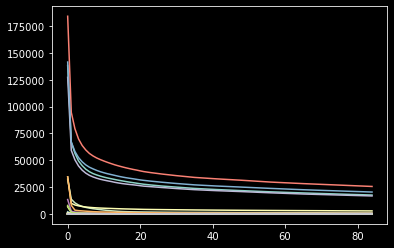

In [143]:
plt.plot(radii,coocs.diagonal())

In [144]:
len(sdata.stats)

83

In [137]:
sorted(coocs.diagonal()[0]/2.1)

[3770.0, 16380.0, 60473.33333333333]

In [139]:
coocs.shape

(2, 2, 32)